# Technical Analysis

## Integrantes:
- Efren Rivera Hernandez
- José Alfonso Martinez Ramirez
- Carola Navarro Badía
- Jose Pablo Vazquez Z

In [197]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import ta
# Importa la librería necesaria
from ta.momentum import RSIIndicator


In [2]:
training = pd.read_csv("aapl_1m_train.csv")

In [3]:
training.head(5)

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1672736400,0,2023-01-03 09:00:00,130.28,131.00,130.28,131.00,8174
1,1,1672736460,0,2023-01-03 09:01:00,130.87,131.17,130.87,131.10,8820
2,2,1672736520,0,2023-01-03 09:02:00,131.18,131.24,131.17,131.17,2112
3,3,1672736580,0,2023-01-03 09:03:00,131.19,131.29,131.19,131.28,3888
4,4,1672736640,0,2023-01-03 09:04:00,131.28,131.46,131.28,131.46,5984


In [5]:
test = pd.read_csv("/Users/carolanavarro/Documents/ITESO/8vo semestre/Trading/data/aapl_1m_test.csv")

In [6]:
test.head(5)

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1693555200,0,2023-09-01 08:00:00,188.33,188.54,188.15,188.32,204
1,1,1693555260,0,2023-09-01 08:01:00,188.24,188.47,188.24,188.26,38
2,2,1693555320,0,2023-09-01 08:02:00,188.33,188.36,188.30,188.32,26
3,3,1693555380,0,2023-09-01 08:03:00,188.32,188.34,188.30,188.30,50
4,4,1693555440,0,2023-09-01 08:04:00,188.34,188.35,188.16,188.16,863


In [7]:
class Operation:
    def __init__(self, operation_type, bought_at, timestamp, 
                 n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.sold_at = None
        self.stop_loss = stop_loss
        self.take_profit = take_profit

In [ ]:
cash = 1000000
active_operations = []
com = 0.00125
strategy_value = [1000000]

for i, row in data.iterrows():

    # Close opearations
    temp_operations= []
    for op in active_operations:
        # Close losing positions
        if op.stop_loss > row.Close:
            cash += row.Close * (1 - com)

        # Close profit
        elif op.take_profit < row.Close: 
            cash += row.Close * (1 - com)

        else:
            temp_operations.append(op)

    active_operations = temp_operations

    # Do we have enough cash?
    if cash > row.Close * (1 + com):

        # buy signal
        if row.Close > row.Open:
            active_operations.append(Operation(operation_type="long",
                                            bought_at=row.Close,
                                                timestamp= row.Timestamp, 
                                                n_shares=1,
                                                stop_loss=row.Close * 0.95,
                                                take_profit=row.Close * 1.05))
            
            cash -= row.Close * (1 + com)

    # Calculate open positions value
    total_value = len(active_operations) * row.Close
    strategy_value.append(cash + total_value)


# Poncho Intento

In [433]:
data = training.copy()

In [434]:
# Convertimos 'Datetime' a datetime para poder calcular las medias móviles
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Calculando indicadores técnicos
# SMA: Simple Moving Average de 20 periodos
data['SMA'] = data['Close'].rolling(window=20).mean()
data['SMA_5'] = data['Close'].rolling(window=5).mean()

# EMA: Exponential Moving Average de 20 periodos
data['EMA'] = data['Close'].ewm(span=20, adjust=False).mean()

# Bollinger Bands
rolling_mean = data['Close'].rolling(window=20).mean()
rolling_std = data['Close'].rolling(window=20).std()
data['BBANDS_UpperBand'] = rolling_mean + (rolling_std * 2)
data['BBANDS_LowerBand'] = rolling_mean - (rolling_std * 2)

# MACD (Moving Average Convergence Divergence)
# Nota: Los periodos comunes son 26 para la EMA lenta y 12 para la rápida
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Estocástico
low_min = data['Low'].rolling(window=14).min()
high_max = data['High'].rolling(window=14).max()
data['K'] = ((data['Close'] - low_min) / (high_max - low_min)) * 100
data['D'] = data['K'].rolling(window=3).mean()

# Calcula el RSI directamente sin cambiar el índice
data['RSI'] = RSIIndicator(close=data['Close'], window=14).rsi()


In [436]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Primero, vamos a preparar nuestros datos para el modelo de ML
# Supongamos que usamos SMA, EMA y MACD como nuestras características (X) y el precio de cierre como la etiqueta (y)
X = data[['SMA', 'EMA', 'MACD','RSI']]
primer_valor_no_nulo = X[['SMA','RSI']].dropna().iloc[0]  # Selecciona el primer valor no nulo en la columna
X[['SMA','RSI']] = X[['SMA','RSI']].fillna(primer_valor_no_nulo)


y = data['Close']


# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
print(f"Error cuadrático medio del modelo: {mse}")

# Usar el modelo entrenado para hacer predicciones en el conjunto de datos completo
data['Predicted_Close'] = model.predict(X)



Error cuadrático medio del modelo: 0.009498873785152386


C:\Users\joalf\AppData\Local\Temp\ipykernel_22448\1416107220.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['SMA','RSI']] = X[['SMA','RSI']].fillna(primer_valor_no_nulo)


In [437]:
class Operation:
    def __init__(self, operation_type, price_at, timestamp, n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.price_at = price_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.stop_loss = stop_loss
        self.take_profit = take_profit

# Variables iniciales
cash = 1000000
active_operations = []
com = 0.00125
strategy_value = [cash]  # Un millón en efectivo
num_shares_short = 5
num_shares_long = 5


# Factores de stop loss y take profit para operaciones cortas
stop_loss_factor_short = 1.02  # 2% por encima del precio de venta
take_profit_factor_short = 0.98  # 2% por debajo del precio de venta

# Factores de stop loss y take profit para operaciones largas
stop_loss_factor_long = 0.97  # 3% por debajo del precio de compra
take_profit_factor_long = 1.07  # 7% por arriba del precio de compra


for row in data.itertuples():

    # Cerrar operaciones
    temp_operations = []
    for op in active_operations:
        if op.operation_type == "long":
            if op.stop_loss > row.Close or op.take_profit < row.Close:
                cash += op.n_shares * row.Close * (1 - com)
            else:
                temp_operations.append(op)
        elif op.operation_type == "short":
            if op.stop_loss < row.Close or op.take_profit > row.Close:
                cash += op.n_shares * (op.price_at - row.Close) * (1 - com)
            else:
                temp_operations.append(op)

    active_operations = temp_operations

    # Comprobar condiciones para operaciones largas
    if cash > row.Close * (1 + com):
        conditions_met_long = sum([
            row.Close > row.SMA,
            row.Close > row.EMA,
            row.Close > row.BBANDS_LowerBand,
            row.D > row.K,
            row.MACD > row.MACD_Signal
        ])

        if conditions_met_long >= 3:
            n_shares_long = num_shares_long  # Definir lógica para cantidad de acciones
            active_operations.append(Operation(
                operation_type="long",
                price_at=row.Close,
                timestamp=row.Index,
                n_shares=n_shares_long,
                stop_loss=row.Close * stop_loss_factor_long,
                take_profit=row.Close * take_profit_factor_long
            ))
            cash -= row.Close * n_shares_long * (1 + com)

    # Comprobar condiciones para operaciones cortas
    conditions_met_short = sum([
        row.Close < row.SMA_5,
        row.Close < row.SMA,
        row.MACD < 0,
        row.MACD < row.MACD_Signal,
        row.RSI > 70,
        row.Close < row.BBANDS_LowerBand,
    ])

    if cash > row.Close * (1 + com) and conditions_met_short >= 5:
        n_shares_short = num_shares_short  
        active_operations.append(Operation(
            operation_type="short",
            price_at=row.Close,
            timestamp=row.Index,
            n_shares=n_shares_short,
            stop_loss=row.Close * stop_loss_factor_short,
            take_profit=row.Close * take_profit_factor_short
        ))

    # Calcular el valor de la estrategia
    total_value_long = sum(op.n_shares * row.Close for op in active_operations if op.operation_type == "long")
    total_value_short = sum(op.n_shares * (op.price_at - row.Close) for op in active_operations if op.operation_type == "short")
    strategy_value.append(cash + total_value_long + total_value_short)

# Convertir la lista de valores de la estrategia en un DataFrame
strategy_value_df = pd.DataFrame(strategy_value, columns=['Strategy Value'])

# Unirlo con el DataFrame 'data' por el índice
final_df = pd.concat([data, strategy_value_df], axis=1)


<function matplotlib.pyplot.show(close=None, block=None)>

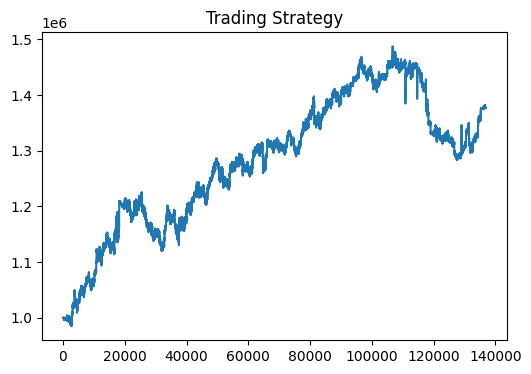

In [439]:
plt.figure(figsize=(6,4))
plt.plot(strategy_value_df)
plt.title("Trading Strategy")
plt.show

***
### Solo LONG

In [109]:
class Operation:
    def __init__(self, operation_type, bought_at, timestamp, n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.stop_loss = stop_loss
        self.take_profit = take_profit

# Variables iniciales
cash = 1000000
active_operations = []
com = 0.00125
strategy_value = [cash]  # Un millón en efectivo

for row in data.itertuples():

    # Cerrar operaciones
    temp_operations = []
    for op in active_operations:
        if op.stop_loss > row.Close:  # Cerrar posiciones perdedoras
            cash += op.n_shares * row.Close * (1 - com)
        elif op.take_profit < row.Close:  # Cerrar posiciones con beneficio
            cash += op.n_shares * row.Close * (1 - com)
        else:
            temp_operations.append(op)

    active_operations = temp_operations

    # Comprobar si tenemos suficiente efectivo y condiciones de los indicadores
    if cash > row.Close * (1 + com):
        # Contar cuántas condiciones de compra se cumplen
        conditions_met = sum([
            row.Close > row.SMA,  # Precio sobre la SMA
            row.Close > row.EMA,  # Precio sobre la EMA
            row.Close > row.BBANDS_LowerBand,  # Precio por encima de la banda inferior de Bollinger
            row.D > row.K,  # La línea D del estocástico sobre la línea K
            row.MACD > row.MACD_Signal  # Línea MACD sobre la señal MACD
        ])

        if conditions_met >= 3:  # Cambiado de todas las condiciones a al menos tres
            # Comprar 1 acción como ejemplo
            n_shares = 1  # Definir cuántas acciones comprar basado en alguna lógica
            active_operations.append(Operation(
                operation_type="long",
                bought_at=row.Close,
                timestamp=row.Index,  # Asumiendo que row.Index es el timestamp
                n_shares=n_shares,
                stop_loss=row.Close * 0.97,
                take_profit=row.Close * 1.07
            ))
            cash -= row.Close * n_shares * (1 + com)

    # Calcular el valor de las posiciones abiertas
    total_value = sum(op.n_shares * row.Close for op in active_operations)
    strategy_value.append(cash + total_value)

# Al final del bucle, convierta la lista de valores de la estrategia en un DataFrame si es necesario
strategy_value_df = pd.DataFrame(strategy_value, columns=['Strategy Value'])

# Suponiendo que quieras unirlo con tu DataFrame 'data' por el índice
final_df = pd.concat([data, strategy_value_df], axis=1)


<function matplotlib.pyplot.show(close=None, block=None)>

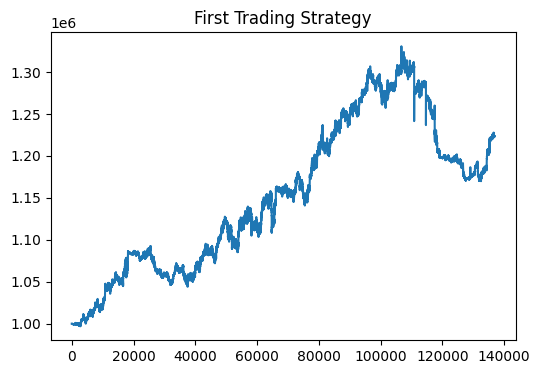

In [112]:
plt.figure(figsize=(6,4))
plt.plot(strategy_value_df)
plt.title("First Trading Strategy")
plt.show

C:\Users\joalf\AppData\Local\Temp\ipykernel_22448\2129319396.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal_Long'][short_window:] = np.where(data['Short_MA'][short_window:] > data['Long_MA'][short_window:], 1.0, 0.0)
C:\Users\joalf\AppData\Local\Temp\ipykernel_22448\2129319396.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal_Short'][short_window:] = np.where(data['Short_MA'][short_window:] < data['Long_MA'][short_window:], -1.0, 0.0)


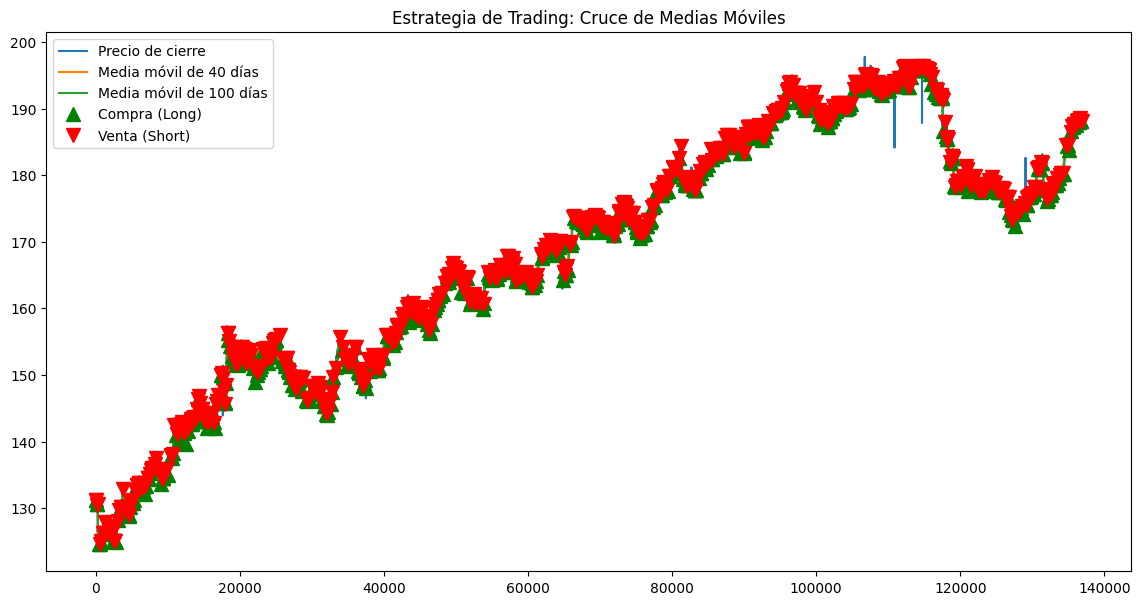

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Asumiendo que 'data' es un DataFrame de Pandas con una columna 'Close' que representa el precio de cierre

# Calcular las medias móviles
short_window = 40
long_window = 100

data['Short_MA'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
data['Long_MA'] = data['Close'].rolling(window=long_window, min_periods=1).mean()

# Señales para la estrategia Long
data['Signal_Long'] = 0.0
data['Signal_Long'][short_window:] = np.where(data['Short_MA'][short_window:] > data['Long_MA'][short_window:], 1.0, 0.0)
data['Positions_Long'] = data['Signal_Long'].diff()

# Señales para la estrategia Short
data['Signal_Short'] = 0.0
data['Signal_Short'][short_window:] = np.where(data['Short_MA'][short_window:] < data['Long_MA'][short_window:], -1.0, 0.0)
data['Positions_Short'] = data['Signal_Short'].diff()

# Plotting
plt.figure(figsize=(14,7))

# Plotting the prices
plt.plot(data['Close'], label='Precio de cierre')

# Plotting the short and long moving averages
plt.plot(data['Short_MA'], label=f'Media móvil de {short_window} días')
plt.plot(data['Long_MA'], label=f'Media móvil de {long_window} días')

# Plotting the buy signals
plt.plot(data[data['Positions_Long'] == 1].index, 
         data['Short_MA'][data['Positions_Long'] == 1], 
         '^', markersize=10, color='g', lw=0, label='Compra (Long)')

# Plotting the sell signals
plt.plot(data[data['Positions_Short'] == -1].index, 
         data['Short_MA'][data['Positions_Short'] == -1], 
         'v', markersize=10, color='r', lw=0, label='Venta (Short)')

plt.title('Estrategia de Trading: Cruce de Medias Móviles')
plt.legend()
plt.show()


***
### Solo SHORT

In [423]:
class Operation:
    def __init__(self, operation_type, sold_at, timestamp, n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.sold_at = sold_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.stop_loss = stop_loss
        self.take_profit = take_profit

# Variables iniciales
cash = 1000000
active_operations = []
com = 0.00125
strategy_value = [cash]  # Un millón en efectivo

# Puedes ajustar estos valores basándote en el backtesting
stop_loss_factor = 1.02  # 3% por encima del precio de venta
take_profit_factor = 0.98  # 5% por debajo del precio de venta


for row in data.itertuples():

    # Cerrar operaciones
    temp_operations = []
    for op in active_operations:
        if op.stop_loss < row.Close:  # Cerrar posiciones perdedoras para un short
            cash -= op.n_shares * (row.Close - op.sold_at) * (1 + com)  # Se pierde cuando el precio sube
        elif op.take_profit > row.Close:  # Cerrar posiciones con beneficio para un short
            cash += op.n_shares * (op.sold_at - row.Close) * (1 - com)  # Se gana cuando el precio baja
        else:
            temp_operations.append(op)

    active_operations = temp_operations

    # Comprobar si tenemos suficiente efectivo y condiciones de los indicadores
    # Aquí, cambia las condiciones para que reflejen una oportunidad de venta (short)
    # Ajuste de condiciones de entrada
    if cash > row.Close * (1 + com) and row.Close < row.Predicted_Close and row.D < 20 and row.K < row.D:
        conditions_met = sum([
            row.Close < row.SMA_5,  # Precio bajo la SMA de 5 periodos
            row.Close < row.SMA,  # Precio bajo la SMA de 20 periodos
            row.MACD < 0,  # MACD por debajo de 0
            row.MACD < row.MACD_Signal,  # Línea MACD bajo la señal MACD
            row.RSI > 70,
            # row.D < 20 and row.K < row.D,  # Estocástico indicando sobreventa y tendencia a la baja 
            row.Close < row.BBANDS_LowerBand,  # Precio por debajo de la banda inferior de Bollinger (para un short, esto podría ser una señal de continuación)
        ])

        if conditions_met >= 5:  # Incrementar el número de condiciones requeridas
            n_shares =  5 # Esto asegura que no gastas más del efectivo disponible
            active_operations.append(Operation(
                operation_type="short",
                sold_at=row.Close,
                timestamp=row.Index,  # Asumiendo que row.Index es el timestamp
                n_shares=n_shares,
                stop_loss=row.Close * stop_loss_factor,
                take_profit=row.Close * take_profit_factor
            ))

    # Calcular el valor de las posiciones abiertas (para shorts, es un poco diferente)
    total_value = cash + sum((op.sold_at - row.Close) * op.n_shares for op in active_operations)  # Valor actual de las posiciones cortas
    strategy_value.append(total_value)

# Al final del bucle, convierte la lista de valores de la estrategia en un DataFrame si es necesario
strategy_value_df = pd.DataFrame(strategy_value, columns=['Strategy Value'])

# Suponiendo que quieras unirlo con tu DataFrame 'data' por el índice
final_df = pd.concat([data, strategy_value_df], axis=1)


<function matplotlib.pyplot.show(close=None, block=None)>

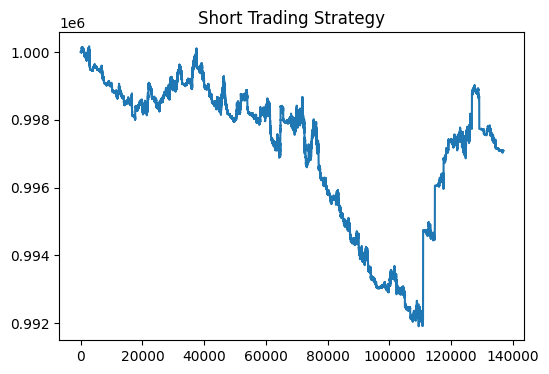

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(strategy_value_df)
plt.title("Short Trading Strategy")
plt.show